## Нормализация БД

### Определение текущей нормальной формы

**Текущая таблица представлена в 1НФ**, так как все атрибуты простые, содержат только скалярные значения. Но при этом есть столбцы, которые не являются ключом, и при этом не зависят от первичного ключа: 
**в таблице transaction - это столбцы brand, production_line, production_class, production_size, list_price и standard_cost**. Эти поля скорее относятся к информации о продукте, поэтому их можно вынести в отдельную таблицу product, а в основной таблице transaction должен остаться только внешний ключ production_id.
**В customer так же имеются не зависящие от первичного ключа столбцы - это postcode, state и country.** Их так же можно вынести в отдельную таблицу postal_object, при этом в таблице customer должен появиться внешний ключ на postal_object (postal_object_id).

### Приведение текущей нормальной формы к 3НФ

**Для того, чтобы привести таблицы к 3НФ необходимо так же избавиться от транзитивных зависимостей.** Такие имеются **в таблице customer - столбцы job_industry_category и wealth_segment имеют прямое отношение к профессии, но не имеют прямого отношения к покупателю.** Поэтому их также можно перенести в таблицу job вместе с job_title, а в таблице customer оставить только ссылку на внешнюю таблицу в виде job_id (который нужно будет сгенерировать при загрузке данных в таблицу job и смаппить на таблицу customer через составной ключ, состоящий из значений job_title, job_industry_category и wealth_segment).


#### Какие изменения еще были произведены дополнительно: 
1. **Изменение наименования столбцов:**

   **transaction.transaction_id -> transaction.id**

   **product.product_id -> product.product_number**, так как больше не является внешним ключем в transaction и не является первичным ключем в новой таблице product (это поле скорее является частью составного ключа из полей product_id, brand, product_line, product_class, product_size, обеспечивающих уникальность продукта)
   
   **customer.customer_id -> customer.id**
   
   **customer.DOB -> customer.date_of_birthday**
   
3. **Изменены типы для некоторых столбцов:**

   transaction.**transaction_date: была строка, преобразован в формат date**

   
   **product.list_price и product.standard_cost: запятая заменена на точку**, чтобы поддержать конвертацию в тип float

5. **Добавлены внешние ключи:**

   **transaction.product_id теперь ссылается на product.id, старое значение transaction.product_id перенесено в столбец product.product_number**, так как не является уникальным и не может быть первичным ключем для таблицы product

   **customer.job_id ссылается на сгенерированный в БД первичный ключ job.id**, так как после переноса выделенных полей в таблице job по сути нет первичного ключа, уникальность обеспечивается за счет сочетания трех полей - job_title, job_industry_category и wealth_segment, при этом job_title может отсутствовать.

   **customer.postal_object_id ссылается на сгенерированный в БД первичный ключ postal_object.id**, ситуация схожа с предыдущей, после переноса полей postcode, state и country в таблицу postal_object и удаления всех дубликатов, очевидно что postcode не может являться уникальным ключем и нужна генерация отдельного уникального ID, так как уникальность обечспечивается за счет сочетания двух полей postcode и state.

### Ниже представлена обновленная схема базы данных, соответствующая 3НФ:

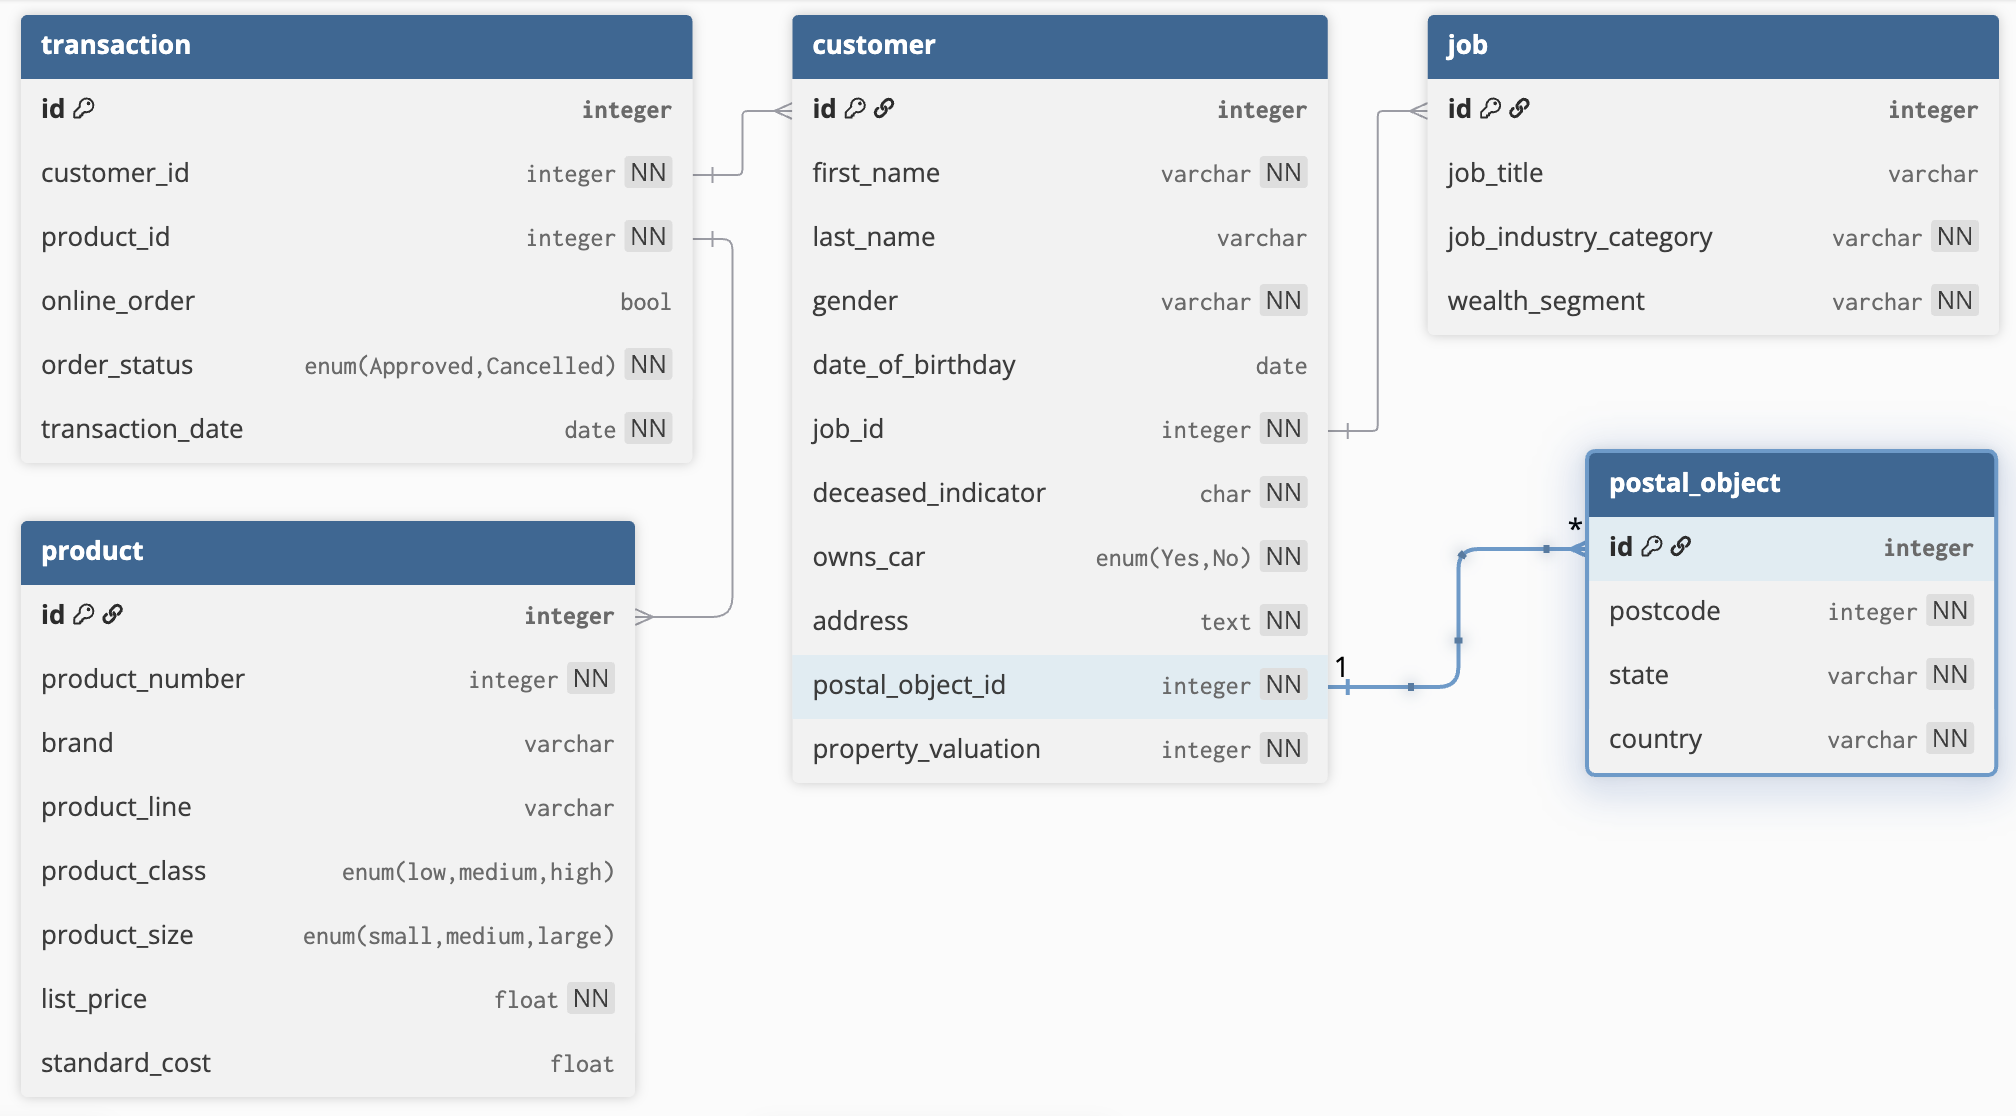

**ER-диаграмма системы**

```dbml
Table transaction {
  id integer [primary key]
  customer_id integer [not null]
  product_id integer [not null]
  online_order bool
  order_status enum('Approved','Cancelled') [not null]
  transaction_date date [not null]
}

Table customer {
  id integer [primary key]
  first_name varchar [not null]
  last_name varchar
  gender varchar [not null]
  date_of_birthday date
  job_id integer [not null]
  deceased_indicator char [not null]
  owns_car enum('Yes','No') [not null]
  address text [not null]
  postal_object_id integer [not null]
  property_valuation integer [not null]
}

Table job {
  id integer [primary key]
  job_title varchar
  job_industry_category varchar [not null]
  wealth_segment varchar [not null]
}

Table postal_object {
  id integer [primary key]
  postcode integer [not null]
  state varchar [not null]
  country varchar [not null]
}

Table product {
  id integer [primary key]
  product_number integer [not null]
  brand varchar
  product_line varchar
  product_class enum('low', 'medium', 'high')
  product_size enum('small', 'medium', 'large')
  list_price float [not null]
  standard_cost float 
}

Ref: transaction.customer_id < customer.id

Ref: transaction.product_id < product.id

Ref: customer.job_id < job.id

Ref: customer.postal_object_id < postal_object.id
```
   

In [1]:
import sys
import os
import psycopg2
import pandas as pd

from pathlib import Path
from psycopg2.extras import execute_values, DictCursor
from datetime import datetime

os.environ['PG_CONFIG'] = '/opt/homebrew/bin/pg_config'
!{sys.executable} -m pip install psycopg2-binary

In [2]:
# Connecting to the database
connection = psycopg2.connect(
    host="localhost",
    database="homework_1",
    user="postgres",
    password="iamroot",
    port="5432"
)
cursor = connection.cursor()
print('Получено соединение с БД')

Получено соединение с БД


## Создание таблиц

Перед созданием каждой таблицы зададим последовательность для генерации ID 

**1. transaction:**
   
```dbml
CREATE SEQUENCE IF NOT EXISTS transaction_id_seq;

CREATE TABLE IF NOT EXISTS transaction (
    id BIGINT PRIMARY KEY DEFAULT nextval('transaction_id_seq'),
    customer_id BIGINT NOT NULL,
    product_id BIGINT NOT NULL,
    online_order BOOLEAN,
    order_status VARCHAR NOT NULL CHECK (order_status IN ('Approved', 'Cancelled')),
    transaction_date DATE NOT NULL
);
```

**2. customer**
   
```dbml
CREATE SEQUENCE IF NOT EXISTS customer_id_seq;

CREATE TABLE IF NOT EXISTS customer (
    id BIGINT PRIMARY KEY DEFAULT nextval('customer_id_seq'),
    first_name VARCHAR NOT NULL,
    last_name VARCHAR,
    gender VARCHAR NOT NULL,
    date_of_birthday DATE,
    job_id INTEGER NOT NULL,
    deceased_indicator CHAR(1) NOT NULL,
    owns_car VARCHAR NOT NULL CHECK (owns_car IN ('Yes','No')),
    address TEXT NOT NULL,
    postal_object_id INTEGER NOT NULL,
    property_valuation INTEGER NOT NULL
);
```   

**3. product**

```dbml
CREATE SEQUENCE IF NOT EXISTS product_id_seq;

CREATE TABLE IF NOT EXISTS product (
    id BIGINT PRIMARY KEY DEFAULT nextval('product_id_seq'),
    product_number INTEGER NOT NULL,
    brand VARCHAR,
    product_line VARCHAR,
    product_class VARCHAR CHECK (product_class IN ('low', 'medium', 'high')),
    product_size VARCHAR CHECK (product_size IN ('small', 'medium', 'large')),
    list_price FLOAT NOT NULL,
    standard_cost FLOAT
);
```

**4. job**

```dbml
CREATE SEQUENCE IF NOT EXISTS job_id_seq;

CREATE TABLE IF NOT EXISTS job (
  id INTEGER PRIMARY KEY DEFAULT nextval('job_id_seq'),
  job_title VARCHAR,
  job_industry_category VARCHAR NOT NULL,
  wealth_segment VARCHAR NOT NULL
);
```

**5. postal_object**

```dbml
CREATE SEQUENCE IF NOT EXISTS postal_object_id_seq;

CREATE TABLE IF NOT EXISTS postal_object (
  id INTEGER PRIMARY KEY DEFAULT nextval('postal_object_id_seq'),
  postcode INTEGER NOT NULL,
  state VARCHAR NOT NULL,
  country VARCHAR NOT NULL
)
```

In [3]:
CREATE_TABLE_QUERY = """
CREATE SEQUENCE IF NOT EXISTS transaction_id_seq;

CREATE TABLE IF NOT EXISTS transaction (
    id BIGINT PRIMARY KEY DEFAULT nextval('transaction_id_seq'),
    customer_id BIGINT NOT NULL,
    product_id BIGINT NOT NULL,
    online_order BOOLEAN,
    order_status VARCHAR NOT NULL CHECK (order_status IN 
    ('Approved', 'Cancelled')
    ),
    transaction_date DATE NOT NULL
);

CREATE SEQUENCE IF NOT EXISTS customer_id_seq;

CREATE TABLE IF NOT EXISTS customer (
    id BIGINT PRIMARY KEY DEFAULT nextval('customer_id_seq'),
    first_name VARCHAR NOT NULL,
    last_name VARCHAR,
    gender VARCHAR NOT NULL,
    date_of_birthday DATE,
    job_id INTEGER NOT NULL,
    deceased_indicator CHAR(1) NOT NULL,
    owns_car VARCHAR NOT NULL CHECK (owns_car IN ('Yes','No')),
    address TEXT NOT NULL,
    postal_object_id INTEGER NOT NULL,
    property_valuation INTEGER NOT NULL
);

CREATE SEQUENCE IF NOT EXISTS product_id_seq;

CREATE TABLE IF NOT EXISTS product (
    id BIGINT PRIMARY KEY DEFAULT nextval('product_id_seq'),
    product_number INTEGER NOT NULL,
    brand VARCHAR,
    product_line VARCHAR,
    product_class VARCHAR CHECK (product_class IN 
    ('low', 'medium', 'high')
    ),
    product_size VARCHAR CHECK (product_size IN 
    ('small', 'medium', 'large')
    ),
    list_price FLOAT NOT NULL,
    standard_cost FLOAT
);

CREATE SEQUENCE IF NOT EXISTS job_id_seq;

CREATE TABLE IF NOT EXISTS job (
  id INTEGER PRIMARY KEY DEFAULT nextval('job_id_seq'),
  job_title VARCHAR,
  job_industry_category VARCHAR NOT NULL,
  wealth_segment VARCHAR NOT NULL
);

CREATE SEQUENCE IF NOT EXISTS postal_object_id_seq;

CREATE TABLE IF NOT EXISTS postal_object (
  id INTEGER PRIMARY KEY DEFAULT nextval('postal_object_id_seq'),
  postcode INTEGER NOT NULL,
  state VARCHAR NOT NULL,
  country VARCHAR NOT NULL
)
"""

In [4]:
# Creating tables
cursor.execute(CREATE_TABLE_QUERY)
connection.commit()
print('Таблицы созданы')

Таблицы созданы


## Добавление ограничений на внешние ключи

**Ссылки на внешние ключи есть только у 2-ух главных таблиц, transaction ссылается на таблицы customer и product, а customer - на таблицы job и postal_object**

**1. transaction:**
   
```dbml
ALTER TABLE IF EXISTS transaction
ADD CONSTRAINT fk_transaction_customer
FOREIGN KEY (customer_id) REFERENCES customer(id);

ALTER TABLE IF EXISTS transaction
ADD CONSTRAINT fk_transaction_product
FOREIGN KEY (product_id) REFERENCES product(id);
```

**2. customer:**
   
```dbml
ALTER TABLE IF EXISTS customer
ADD CONSTRAINT fk_customer_job
FOREIGN KEY (job_id) REFERENCES job(id);

ALTER TABLE IF EXISTS customer
ADD CONSTRAINT fk_customer_postal_object
FOREIGN KEY (postal_object_id) REFERENCES postal_object(id);
```

In [5]:
ALTER_TABLE_QUERY = """
ALTER TABLE IF EXISTS transaction
ADD CONSTRAINT fk_transaction_customer
FOREIGN KEY (customer_id) REFERENCES customer(id);

ALTER TABLE IF EXISTS transaction
ADD CONSTRAINT fk_transaction_product
FOREIGN KEY (product_id) REFERENCES product(id);

ALTER TABLE IF EXISTS customer
ADD CONSTRAINT fk_customer_job
FOREIGN KEY (job_id) REFERENCES job(id);

ALTER TABLE IF EXISTS customer
ADD CONSTRAINT fk_customer_postal_object
FOREIGN KEY (postal_object_id) REFERENCES postal_object(id);
"""

In [6]:
# Adding restrictions on foreign keys
cursor.execute(ALTER_TABLE_QUERY)
connection.commit()
print('Добавлены ограничения на внешние ключи')

Добавлены ограничения на внешние ключи


## Заполнение данными

**3.1 Сначала заполним справочные таблицы job, postal_object, product, на которые ссылаются основные таблицы transaction и customer.**

postal_object и product заполяются без изменения наименования столбцов, а в product наименование столбца product_id было изменено на product_number, так как в этой таблице этот ID не уникален, вместо него был добавлен отдельный столбец для ID - product.id. 

Пустые значения (пустые строки типа '') при этом заменяются на NULL

Так же для таблицы product необходимо было изменить тип значения с плавающей точкой столбцов list_price и standard_cost, а именно запятая заменена на точку.

In [7]:
def insert_data(pd_data: pd.DataFrame, db_table_name: str) -> None:
    """
    Inserts data from the DataFrame into the specified database table.

    Args:
        pd_data (pd.DataFrame): A DataFrame with the data to insert
        db_table_name (str): The name of the data insertion table
    """
    columns = pd_data.columns.tolist()

    for column in columns:
        pd_data[column] = pd_data[column].apply(
            lambda val: None if pd.isna(val) or val == '' else val
        )

    insert_query = f"""
        INSERT INTO {db_table_name} ({', '.join(columns)})
        VALUES %s
    """

    execute_values(cursor, insert_query, pd_data.values.tolist())

# Inserting data into the tables job, postal_object, product
data_to_insert = {'job', 'postal_object', 'product'}

for table_name in data_to_insert:
    data = pd.read_csv(
        Path(f'data_to_insert/{table_name}.csv'),
        keep_default_na=False
    )
    insert_data(data, table_name)   
print('Таблицы job, postal_object и product заполнены данными')

Таблицы job, postal_object и product заполнены данными


**3.2 Теперь заполним главные таблицы customer и transaction. Таблицу customer нужно наполнить перед transaction, так как transaction ссылается на customer через внешний ключ transaction.customer_id**

**Для того, чтобы определить ID внешних таблиц, которые нужно подставить в столбцы job_id и postal_object_id для таблицы job, и product_id для transaction, нужно определить по какому составному ключу можно смаппить данные и определить актуальный сгенерированный ID** (после того как данные по справочным таблицам были залиты). Если какой-то элемент из составного ключа отсутствует, то заменяется на  символ '_'. Реализация определена в функции **get_ids_by_composite_key** ниже.

**1. необходимые изменения в customer:**
   
   Столбцы, наименование которых было изменено:
   
   customer_id -> id
   
   DOB -> date_of_birthday

   Добавлен внешний ключ job_id, значение которого определяется по составному ключу, состоящему из полей job_title, job_industry_category и wealth_segment (разделенных символом '_'). 
   
   Добавлен внешний ключ postal_object_id, определяется по композитному ключу postcode + _ + state

   Столбцы которые не потребовали никаких изменений: first_name, last_name, gender, deceased_indicator, owns_car, address, property_valuation

**2. необходимые изменения в transaction:**
   
   Столбцы, наименование которыx было изменено:
   
   transaction_id -> id
   
   Изменен тип данных для столбца transaction_date, тип строка был изменен на date
   
   Внешний ключ profuct_id переопределяется по составному ключу, состоящему из полей product_number, brand, product_line, product_class, product_size (разделенных символом '_'). 

   Cтолбцы которые не требуют изменений: customer_id, online_order, order_status

In [8]:
def get_ids_by_composite_key(db_table_name: str, columns: list[str]) \
        -> dict[str, int]:
    """
    Retrieves a dictionary of the correspondence of composite keys to the IDs
    of records in the table.

    Args:
        db_table_name (str): The name of the table in the database from which the
        data is extracted
        columns (list): List of columns for a composite key

    Returns:
        dict: A dictionary where the key is a composite key and the value is ID
    """
    result = dict.fromkeys(columns)

    with connection.cursor(cursor_factory=DictCursor) as dict_cursor:
        dict_cursor.execute(
            f"SELECT id, {', '.join(columns)} FROM {db_table_name}")
        rows = dict_cursor.fetchall()

        for row in rows:
            composite_key = '_'.join(
                [str(row[val]) if row[val] else '_' for val in columns]
            )
            result[composite_key] = row['id']
        return result     

**Сначала получим загруженные данные из таблицы job и postal_object, чтобы получить актуальный ID, который был сгенерирован и присвоен при загрузке в базу данных. Затем смаппим значения столбцов на актуальный ID и загрузим данные в таблицу customer.**

**Была выявлена проблема:** Так как при дальнейшей попытке загрузки в transaction был выявлен потерянный customer_id = 5034, то он был добавлен вручную в скрипт загрузки покупателей
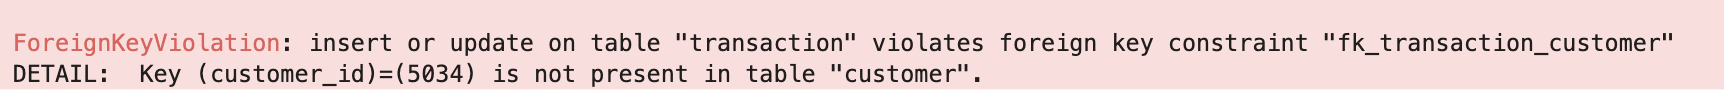

теперь он дублирует информацию по пользователю с ID = 4000, так как актуальных данных пользователю с ID = 5034 нет:
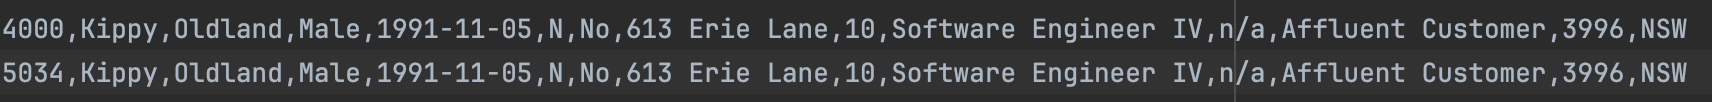

In [9]:
# Getting an ID using composite keys
job_ids_by_composite_key = get_ids_by_composite_key(
    'job',
    ["job_title", "job_industry_category", "wealth_segment"]
)
print('Получен словарь из композитных ключей и актуальных ID для сущностей таблицы job')

postal_object_ids_by_composite_key = get_ids_by_composite_key(
    'postal_object',
    ["postcode", "state"]
)
print('Получен словарь из композитных ключей и актуальных ID для сущностей таблицы postal_object')

# Processing and inserting customer data
data_customer = pd.read_csv(
    Path('data_to_insert/customer.csv'),
    keep_default_na=False
)

data_customer['job_id'] = (
    data_customer[['job_title', 'job_industry_category', 'wealth_segment']]
    .apply(
        lambda x: job_ids_by_composite_key[(
            f'{x["job_title"] if x["job_title"] else "_"}_'
            f'{x["job_industry_category"] if x["job_industry_category"] else "_"}_'
            f'{x["wealth_segment"] if x["wealth_segment"] else "_"}'
        )],
        axis=1
    )
)
print('Добавлен столбец job_id на основании композитного ключа полей job_title, job_industry_category, wealth_segment')

data_customer['postal_object_id'] = (
    data_customer[['postcode', 'state']]
    .apply(
        lambda x: postal_object_ids_by_composite_key[(
            f'{x["postcode"] if x["postcode"] else "_"}_'
            f'{x["state"] if x["state"] else "_"}'
        )],
        axis=1
    )
)
print('Добавлен столбец postal_object_id на основании композитного ключа полей postcode и state')

data_customer = data_customer.drop(
    columns=[
        'job_title', 'job_industry_category', 'wealth_segment',
        'postcode', 'state'
    ]
)
print('Удалены лишние столбцы')

insert_data(data_customer, 'customer')

# Fixing changes in the database
connection.commit() 
print('Таблица customer заполнена данными')

Получен словарь из композитных ключей и актуальных ID для сущностей таблицы job
Получен словарь из композитных ключей и актуальных ID для сущностей таблицы postal_object
Добавлен столбец job_id на основании композитного ключа полей job_title, job_industry_category, wealth_segment
Добавлен столбец postal_object_id на основании композитного ключа полей postcode и state
Удалены лишние столбцы
Таблица customer заполнена данными


**Следующим шагом получим загруженные данные из таблицы product для получения актуального ID:**

In [10]:
# Getting product IDs using a composite key
product_ids_by_composite_key = get_ids_by_composite_key(
    'product',
    [
        "product_number", "brand", "product_line", "product_class",
        "product_size"
    ]
)
print('Получен словарь из композитных ключей и актуальных ID для сущностей таблицы product')

# Processing and inserting transaction data
data_transactions = pd.read_csv(
    Path('data_to_insert/transaction.csv'),
    keep_default_na=False
)

data_transactions['transaction_date'] = pd.to_datetime(
    data_transactions['transaction_date']
)

data_transactions['product_id'] = (
    data_transactions[
        [
            'product_id', 'brand', 'product_line', 'product_class',
            'product_size'
        ]
    ]
    .apply(
        lambda x: product_ids_by_composite_key[(
            f'{x["product_id"] if x["product_id"] else "_"}_'
            f'{x["brand"] if x["brand"] else "_"}_'
            f'{x["product_line"] if x["product_line"] else "_"}_'
            f'{x["product_class"] if x["product_class"] else "_"}_'
            f'{x["product_size"] if x["product_size"] else "_"}'
        )],
        axis=1
    )
)
print('Заменено содержимое столбца production_id на основании композитного ключа полей предыдущего значения product_id, brand, product_line, product_class и product_size')

data_transactions = data_transactions.drop(
    columns=['brand', 'product_line', 'product_class', 'product_size']
)
insert_data(data_transactions, 'transaction')
print('Удалены лишние поля brand, product_line, product_class и product_size перед загрузкой')

# Fixing changes in the database
connection.commit()   
print('Таблица transaction заполнена данными')

Получен словарь из композитных ключей и актуальных ID для сущностей таблицы product
Заменено содержимое столбца production_id на основании композитного ключа полей предыдущего значения product_id, brand, product_line, product_class и product_size
Удалены лишние поля brand, product_line, product_class и product_size перед загрузкой
Таблица transaction заполнена данными


## скрин результата в DBeaver:
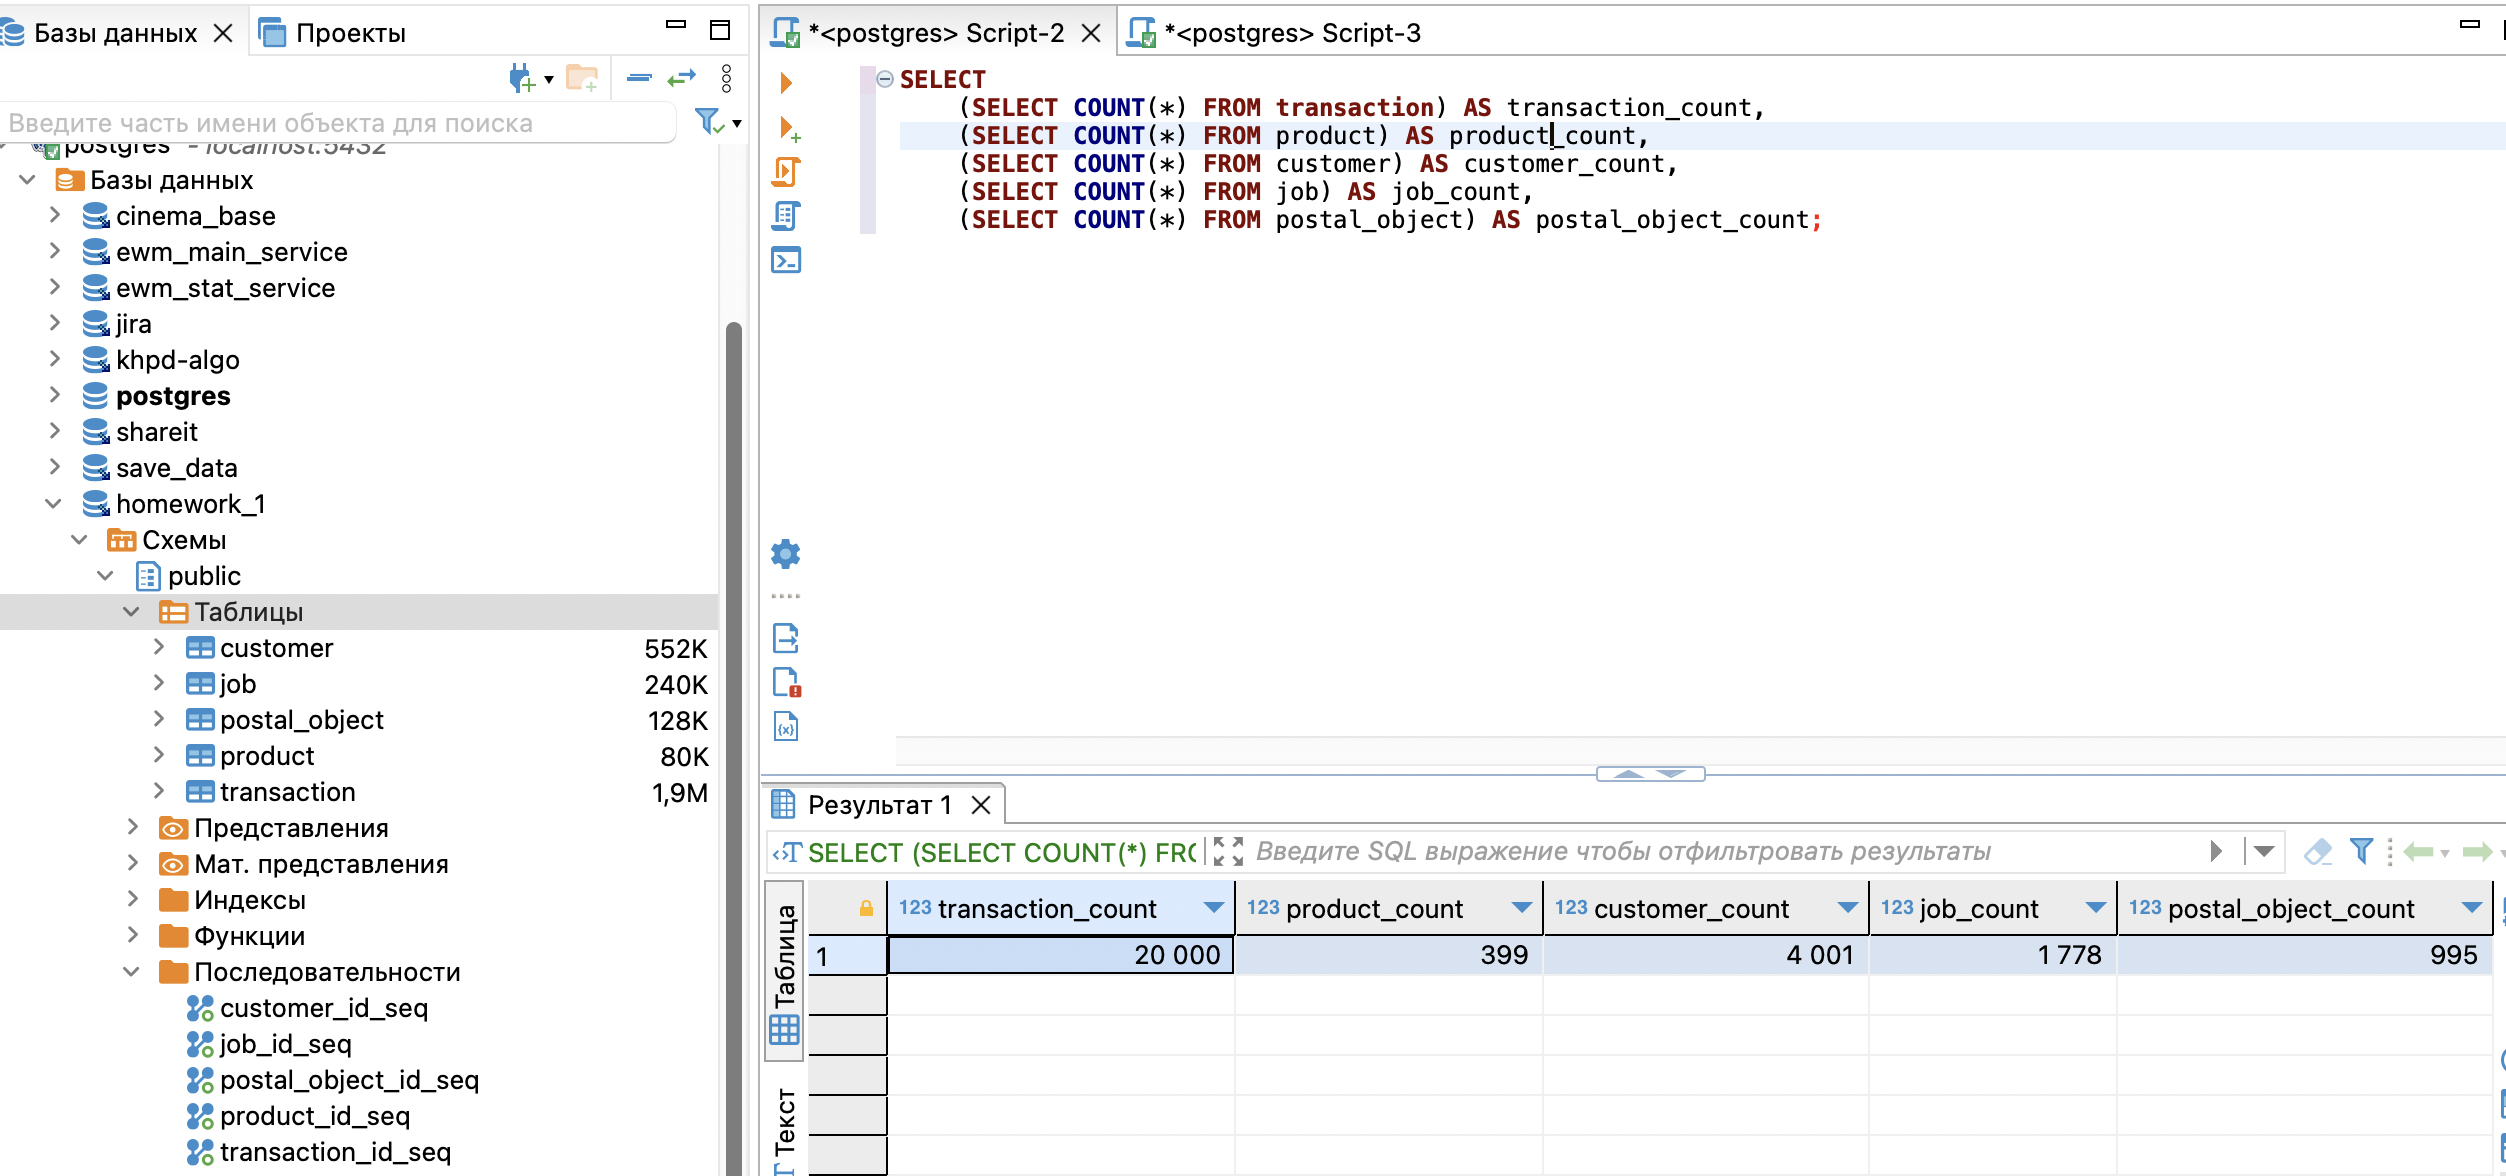